In [1]:
import numpy as np
import math
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt
from numpy.random import beta

from sklearn.model_selection import train_test_split

In [2]:
f1 = open("create_dataset/i80s1.csv", "r")
f2 = open("create_dataset/i80s2.csv", "r")
f3 = open("create_dataset/i80s3.csv", "r")

In [3]:
track_len = 50
stp = 40

batch_size = 30
hidden_dim = 100

In [4]:
# read from files
ts1 = []
cid1 = []
xc1 = []
yc1 = []
ve1 = []
ac1 = []
ts2 = []
cid2 = []
xc2 = []
yc2 = []
ve2 = []
ac2 = []
ts3 = []
cid3 = []
xc3 = []
yc3 = []
ve3 = []
ac3 = []
for l in f1:
    li = l.split(',')
    ts1.append(float(li[0]))
    cid1.append(int(li[1]))
    xc1.append(float(li[2]))
    yc1.append(float(li[3]))
    ve1.append(float(li[4]))
    ac1.append(float(li[5]))

for l in f2:
    li = l.split(',')
    ts2.append(float(li[0]))
    cid2.append(int(li[1]))
    xc2.append(float(li[2]))
    yc2.append(float(li[3]))
    ve2.append(float(li[4]))
    ac2.append(float(li[5]))

for l in f3:
    li = l.split(',')
    ts3.append(float(li[0]))
    cid3.append(int(li[1]))
    xc3.append(float(li[2]))
    yc3.append(float(li[3]))
    ve3.append(float(li[4]))
    ac3.append(float(li[5]))
    
ts1 = np.array(ts1)
cid1 = np.array(cid1)
xc1 = np.array(xc1)
yc1 = np.array(yc1)
ve1 = np.array(ve1)
ac1 = np.array(ac1)
ts2 = np.array(ts2)
cid2 = np.array(cid2)
xc2 = np.array(xc2)
yc2 = np.array(yc2)
ve2 = np.array(ve2)
ac2 = np.array(ac2)
ts3 = np.array(ts3)
cid3 = np.array(cid3)
xc3 = np.array(xc3)
yc3 = np.array(yc3)
ve3 = np.array(ve3)
ac3 = np.array(ac3)

In [5]:
# split data into tracks
trace_len = track_len
un_cid = np.unique(cid1)
tot_trace1 = []
for i in range(len(un_cid)):
    c_id = un_cid[i];
    ixs = [ix for ix in range(len(cid1)) if cid1[ix] == c_id]
        
    if len(ixs) < trace_len:
        continue

    for j in range(0, len(ixs)-trace_len, stp):
        cur_ix = ixs[j]
        trace_ix = []
        for k in range(trace_len):
            next_ix = ixs[j+k]
            trace_ix.append(next_ix)
            cur_ix = next_ix

        tot_trace1.append(trace_ix)
        
un_cid = np.unique(cid2)
tot_trace2 = []
for i in range(len(un_cid)):
    c_id = un_cid[i];
    ixs = [ix for ix in range(len(cid2)) if cid2[ix] == c_id]
        
    if len(ixs) < trace_len:
        continue

    for j in range(0, len(ixs)-trace_len, stp):
        cur_ix = ixs[j]
        trace_ix = []
        for k in range(trace_len):
            next_ix = ixs[j+k]
            trace_ix.append(next_ix)
            cur_ix = next_ix

        tot_trace2.append(trace_ix)
        
un_cid = np.unique(cid3)
tot_trace3 = [];
for i in range(len(un_cid)):
    c_id = un_cid[i];
    ixs = [ix for ix in range(len(cid3)) if cid3[ix] == c_id]
        
    if len(ixs) < trace_len:
        continue

    for j in range(0, len(ixs)-trace_len, stp):
        cur_ix = ixs[j]
        trace_ix = []
        for k in range(trace_len):
            next_ix = ixs[j+k]
            trace_ix.append(next_ix)
            cur_ix = next_ix

        tot_trace3.append(trace_ix)

In [6]:
# build test set
X_test = []
Y_test = []
eps = 0.0001
for i in range(len(tot_trace1)):
    trace_feat = []
    for j in range(trace_len-1):
        ix = tot_trace1[i][j]
        ix2 = tot_trace1[i][j+1]
        th = math.atan((yc1[ix2]-yc1[ix])/(xc1[ix2]-xc1[ix]+eps))
        
        if th < 0:
            th = math.pi + th
        
        node_feat = [xc1[ix], yc1[ix], ve1[ix], ac1[ix], th]
        trace_feat.append(node_feat)

    trace_feat = np.array(trace_feat)
    X_test.append(trace_feat[0:trace_len-3])
    Y_test.append(np.concatenate((trace_feat[1:trace_len-2,0:3],trace_feat[2:trace_len-1,0:3],trace_feat[1:trace_len-2,3:5]), axis=1))
    
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [7]:
len(tot_trace3)

4017

In [8]:
print(X_test.shape)

(3460, 47, 5)


In [9]:
# build train set
X = []
Y = []
for i in range(len(tot_trace2)):
    trace_feat = []
    for j in range(trace_len-1):
        ix = tot_trace2[i][j]
        ix2 = tot_trace2[i][j+1]
        th = math.atan((yc2[ix2]-yc2[ix])/(xc2[ix2]-xc2[ix]+eps))
        
        if th < 0:
            th = math.pi + th
            
        node_feat = [xc2[ix], yc2[ix], ve2[ix], ac2[ix], th]
        trace_feat.append(node_feat)

    trace_feat = np.array(trace_feat)
    X.append(trace_feat[0:trace_len-3])
    Y.append(np.concatenate((trace_feat[1:trace_len-2,0:3],trace_feat[2:trace_len-1,0:3],trace_feat[1:trace_len-2,3:5]), axis=1))
    
for i in range(len(tot_trace3)):
    trace_feat = []
    for j in range(trace_len-1):
        ix = tot_trace3[i][j]
        ix2 = tot_trace3[i][j+1]
        th = math.atan((yc3[ix2]-yc3[ix])/(xc3[ix2]-xc3[ix]+eps))
        
        if th < 0:
            th = math.pi + th
            
        node_feat = [xc3[ix], yc3[ix], ve3[ix], ac3[ix], th]
        trace_feat.append(node_feat)

    trace_feat = np.array(trace_feat)
    X.append(trace_feat[0:trace_len-3])
    Y.append(np.concatenate((trace_feat[1:trace_len-2,0:3],trace_feat[2:trace_len-1,0:3],trace_feat[1:trace_len-2,3:5]), axis=1))
    
X = np.array(X)
Y = np.array(Y)

In [10]:
print(X.shape)

(8300, 47, 5)


In [11]:
# split train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

In [12]:
class buildDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]).float(), torch.tensor(self.Y[idx]).float()

In [13]:
# build dataloader
train_ds = buildDataset(X_train, Y_train)
valid_ds = buildDataset(X_val, Y_val)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [14]:
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([30, 47, 5])
torch.Size([30, 47, 8])


In [15]:
# define model
class LSTM(torch.nn.Module) :
    def __init__(self, feat_dim=5, hidden_dim=100, pred_feat=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(feat_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, pred_feat)
        
    def forward(self, x, h=None, c=None):
        if h is None and c is None:
            h = torch.zeros(1, x.shape[0], self.hidden_dim)
            c = torch.zeros(1, x.shape[0], self.hidden_dim)
            
        lstm_out, (ht, ct) = self.lstm(x, (h, c))
        x = self.fc(lstm_out)
        return x, ht, ct

In [16]:
model = LSTM()
train_loss_li = []
valid_loss_li = []

In [17]:
def train_model(model, train_dl, val_dl, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    dt = 0.2
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y in train_dl:
            l = x.shape[1]
            optimizer.zero_grad()

            y_pred, _, _ = model(x)
        
            next_xc = y[:,:,0:1]
            next_yc = y[:,:,1:2]
            next_ve = y[:,:,2:3]
            next_ac = y_pred[:,:,0:1]
            next_th = y_pred[:,:,1:2]
            
            dist = next_ve * dt + 1/2 * next_ac * dt**2
            nextnext_xc = next_xc + dist * torch.cos(next_th)
            nextnext_yc = next_yc + dist * torch.sin(next_th)
            nextnext_ve = next_ve + next_ac * dt
            
            pred = torch.cat((nextnext_xc, nextnext_yc, nextnext_ve), 2)
            mse_pos = F.mse_loss(pred, y[:,:,3:6])
            mse_ac = F.mse_loss(next_ac, y[:,:,6:7])
            mse_th = F.mse_loss(next_th, y[:,:,7:8])
            
            w1 = 1
            w2 = 4
            w3 = 8
            loss = w1 * mse_pos + w2 * mse_ac + w3 * mse_th
                    
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() * y.shape[0]
            total += y.shape[0]
        val_loss = validation_metrics(model, val_dl)
        print("train loss %.3f, val loss %.3f" % (sum_loss/total, val_loss))
        train_loss_li.append(sum_loss/total)
        valid_loss_li.append(val_loss)

def validation_metrics (model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0.0
    dt = 0.2
    for x, y, in valid_dl:
        y_pred, _, _ = model(x)
    
        next_xc = y[:,:,0:1]
        next_yc = y[:,:,1:2]
        next_ve = y[:,:,2:3]
        next_ac = y_pred[:,:,0:1]
        next_th = y_pred[:,:,1:2]

        dist = next_ve * dt + 1/2 * next_ac * dt**2
        nextnext_xc = next_xc + dist * torch.cos(next_th)
        nextnext_yc = next_yc + dist * torch.sin(next_th)
        nextnext_ve = next_ve + next_ac * dt
            
        pred = torch.cat((nextnext_xc, nextnext_yc, nextnext_ve), 2)
        mse_pos = F.mse_loss(pred, y[:,:,3:6])
        mse_ac = F.mse_loss(next_ac, y[:,:,6:7])
        mse_th = F.mse_loss(next_th, y[:,:,7:8])
        
        w1 = 1
        w2 = 4
        w3 = 8
        loss = w1 * mse_pos + w2 * mse_ac + w3 * mse_th

        sum_loss += loss.item() * y.shape[0]
        total += y.shape[0]
    return sum_loss/total

In [18]:
train_model(model, train_dl, valid_dl, epochs=200, lr=0.001)

train loss 82.055, val loss 68.087
train loss 64.130, val loss 63.278
train loss 62.458, val loss 62.279
train loss 61.762, val loss 61.626
train loss 61.045, val loss 61.476
train loss 60.254, val loss 60.279
train loss 59.550, val loss 59.944
train loss 59.001, val loss 59.349
train loss 58.457, val loss 59.054
train loss 57.968, val loss 59.187
train loss 57.615, val loss 58.631
train loss 57.288, val loss 57.949
train loss 56.963, val loss 57.533
train loss 56.704, val loss 57.363
train loss 56.691, val loss 57.927
train loss 56.317, val loss 56.911
train loss 56.140, val loss 56.942
train loss 56.079, val loss 57.089
train loss 55.824, val loss 56.503
train loss 55.759, val loss 56.865
train loss 55.569, val loss 58.417
train loss 55.501, val loss 56.635
train loss 55.270, val loss 55.965
train loss 55.258, val loss 56.717
train loss 55.062, val loss 56.034
train loss 55.071, val loss 56.041
train loss 54.881, val loss 55.705
train loss 54.739, val loss 55.664
train loss 54.588, v

In [19]:
def nextXYV(cur_xc, cur_yc, cur_ve, cur_ac, cur_th):
    dt = 0.2

    dist = cur_ve * dt + 1/2 * cur_ac * dt**2
    next_xc = cur_xc + dist * math.cos(cur_th)
    next_yc = cur_yc + dist * math.sin(cur_th)
    next_ve = cur_ve + cur_ac * dt
    return next_xc, next_yc, next_ve

In [20]:
def predictFutureFeatures(model, ref_feats, pred_dur):    
    future_feats = []
    ht = torch.zeros(1, 1, hidden_dim)
    ct = torch.zeros(1, 1, hidden_dim)
    next_feat = ref_feats.tolist()[-1]
    ref_feats_tensor = torch.tensor(ref_feats).view(1,-1,5).float()
    for i in range(pred_dur):
        cur_feat = next_feat
        
        cur_xc = cur_feat[0]
        cur_yc = cur_feat[1]
        cur_ve = cur_feat[2]
        cur_ac = cur_feat[3]
        cur_th = cur_feat[4]

        next_xc, next_yc, next_ve = nextXYV(cur_xc, cur_yc, cur_ve, cur_ac, cur_th)
                
        cur_xc = next_xc
        cur_yc = next_yc
        cur_ve = next_ve
        
        pred_feats, ht, ct = model(ref_feats_tensor, ht, ct)
        pred_feats = pred_feats[0].tolist()
        
        next_ac = pred_feats[-1][0]
        next_th = pred_feats[-1][1]
        next_feat = [next_xc, next_yc, next_ve, next_ac, next_th]
        
        future_feats.append(next_feat)
        ref_feats_tensor = torch.tensor(next_feat).view(1, -1, 5).float()
        
    return np.array(future_feats)

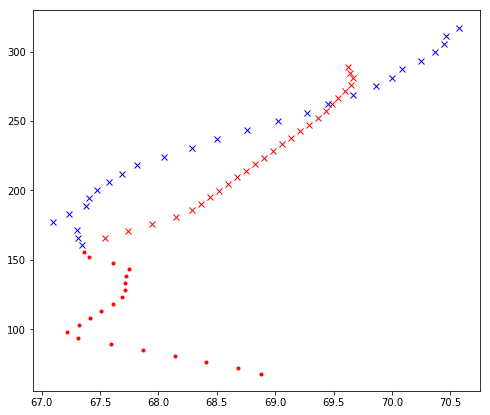

In [30]:
# visualization
model.eval()

n = 23 # path id
ref_dur = 20

pred_dur = X_test.shape[1]-ref_dur
test_X = X_test[n, 0:ref_dur, :]
gt_x = Y_test[n, ref_dur:ref_dur+pred_dur, 0]
gt_y = Y_test[n, ref_dur:ref_dur+pred_dur, 1]
ref_x = X_test[n, 0:ref_dur, 0]
ref_y = X_test[n, 0:ref_dur, 1]
pred_feats = predictFutureFeatures(model, test_X, pred_dur)
pred_x = pred_feats[:, 0]
pred_y = pred_feats[:, 1]

fig,ax = plt.subplots(figsize=(8, 7))
ax.plot(ref_x,ref_y, 'r.', gt_x, gt_y, 'rx', pred_x, pred_y, 'bx')

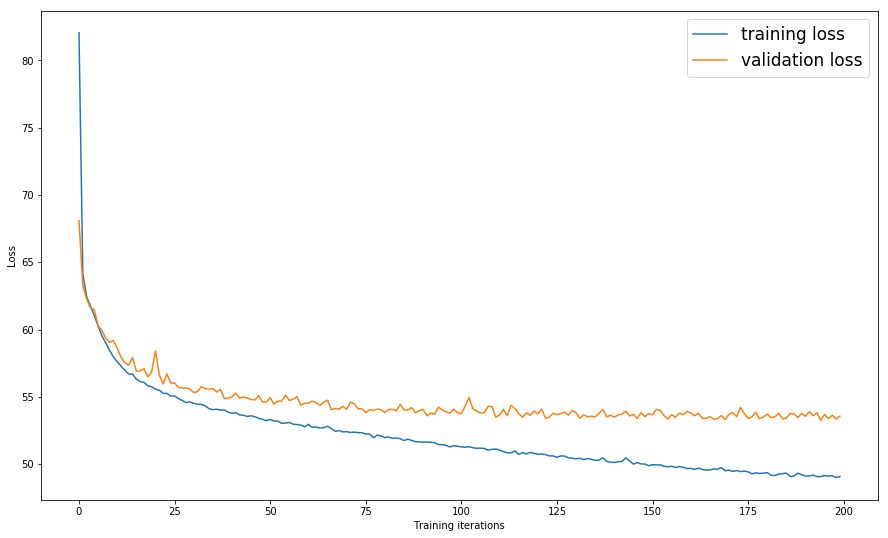

In [22]:
fig,ax = plt.subplots(figsize=(15, 9))
ax.plot(range(len(train_loss_li[0:200])), train_loss_li[0:200], label='training loss')
ax.plot(range(len(valid_loss_li[0:200])), valid_loss_li[0:200], label='validation loss')
ax.set(xlabel='Training iterations', ylabel='Loss')
ax.legend(prop={'size': 17})

In [23]:
def naivePrediction(ref_feats, pred_dur):
    cur_feat = ref_feats[-1]
    cur_xc = cur_feat[0]
    cur_yc = cur_feat[1]
    cur_ve = cur_feat[2]
    cur_th = cur_feat[4]

    pred_pos = []
    for i in range(pred_dur):
        dist = cur_ve * 0.2
        next_xc = cur_xc + dist * math.cos(cur_th)
        next_yc = cur_yc + dist * math.sin(cur_th)
        next_pos = [next_xc, next_yc]
        pred_pos.append(next_pos)

        cur_xc = next_xc
        cur_yc = next_yc
        
    return np.array(pred_pos)

In [24]:
def averagePredictionError(gt_pos, pred_pos):
    sum_dist = 0
    for i in range(len(gt_pos)):
        gt_x = gt_pos[0,i]
        gt_y = gt_pos[1,i]
        pred_x = pred_pos[0,i]
        pred_y = pred_pos[1,i]

        dist = math.sqrt((gt_x-pred_x)**2 + (gt_y-pred_y)**2)
        sum_dist = sum_dist + dist


    avg_dist = sum_dist / len(gt_pos)
    return avg_dist

In [25]:
rd_li = [1, 5, 10, 20, 30, 40]
ni_li = []
ls_li = []

for ref_dur in rd_li:
    ni_err = []
    ls_err = []
#     mini = 1000
    for i in range(len(X_test)):
        feats = X_test[i]
        ref_feats = feats[0:ref_dur]
        gt_feats = feats[ref_dur:len(feats)]
        naive_pred = naivePrediction(ref_feats, len(gt_feats))
        lstm_pred = predictFutureFeatures(model, ref_feats, len(gt_feats))

        n_e = averagePredictionError(gt_feats[0:2], naive_pred)
        l_r = averagePredictionError(gt_feats[0:2], lstm_pred)

        ni_err.append(n_e)
        ls_err.append(l_r)

#         if l_r < mini: # print id of path with smallest error
#             mini = l_r
#             print(ref_dur, i)

    ni_li.append(ni_err)
    ls_li.append(ls_err)

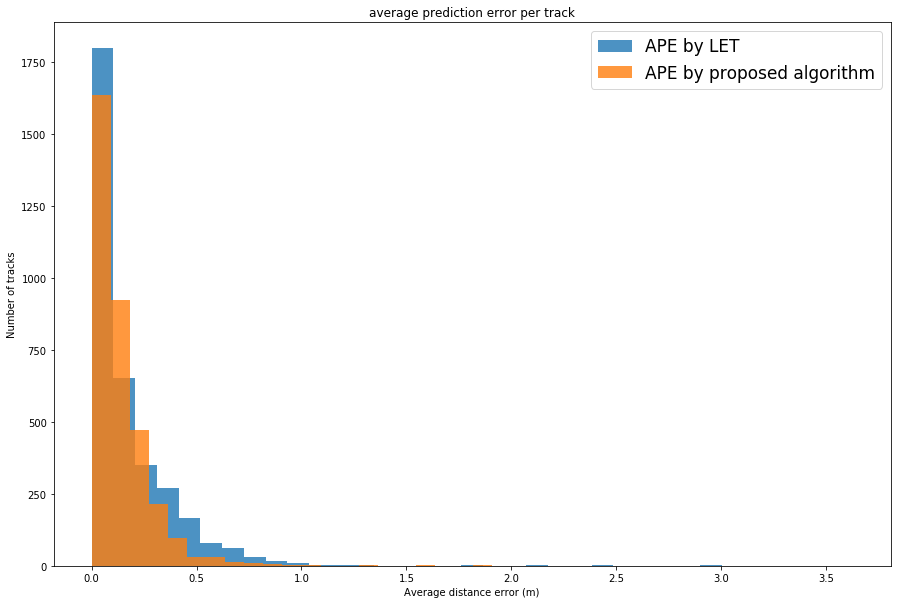

In [26]:
def plot_beta_hist(ax, li, lb):
    ax.hist(li, histtype="stepfilled",
            bins=35, alpha=0.8, label=lb)

fig, ax = plt.subplots(figsize=(15, 10))
plot_beta_hist(ax, ni_li[3], 'APE by LET')
plot_beta_hist(ax, ls_li[3], 'APE by proposed algorithm')
ax.legend(prop={'size': 17})
ax.set(xlabel='Average distance error (m)', ylabel='Number of tracks',
       title="average prediction error per track")
plt.show()

In [27]:
_ls_li = []
_ni_li = []
for i in range(6):
    _ls = sum(ls_li[i]) / X_test.shape[0]
    _ni = sum(ni_li[i]) / X_test.shape[0]
    
    _ls_li.append(float(format(_ls, '.3f')))
    _ni_li.append(float(format(_ni, '.3f')))

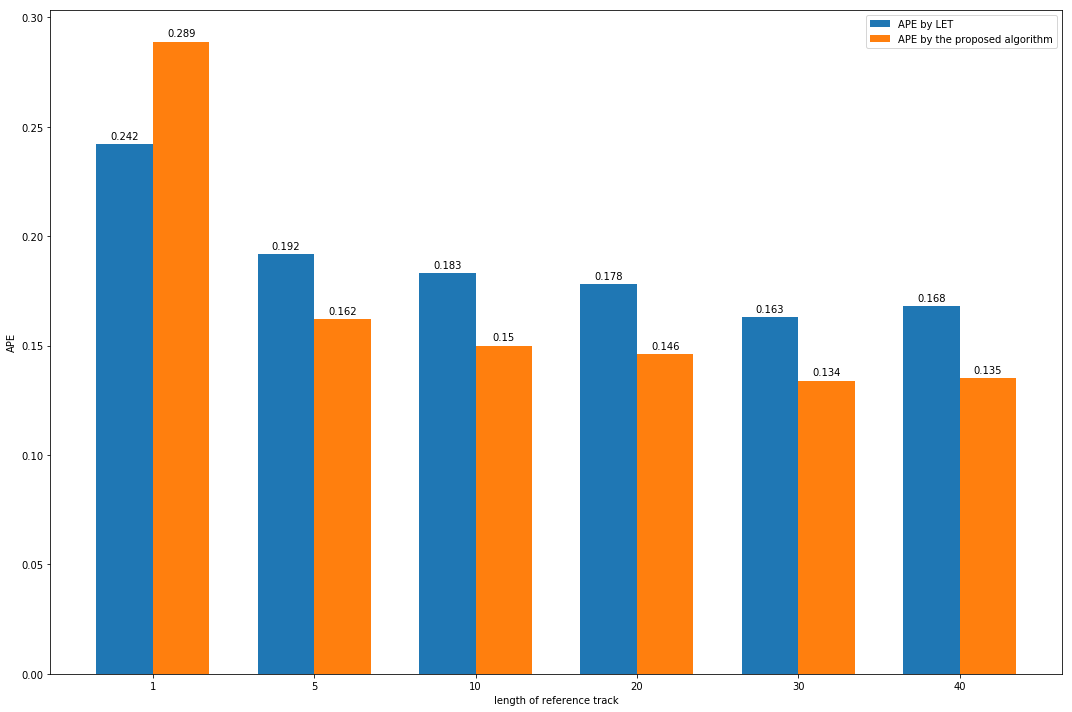

In [28]:
labels = ['1', '5', '10', '20', '30', '40']
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.bar(x - width/2, _ni_li, width, label='APE by LET')
rects2 = ax.bar(x + width/2, _ls_li, width, label='APE by the proposed algorithm')

ax.set_ylabel('APE')
ax.set_xlabel('length of reference track')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()